<a href="https://colab.research.google.com/github/jakedorman64/internship/blob/main/Double_Pendulum_NeuralODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Double Pendulum Simulator

Solving the Euler Lagrange equations for the double pendulum gives the second order differential equations:

$$ \begin{align} \ddot{\theta}_1 & = \frac{g \sin{\theta_2} \cos{(\theta_1 - \theta_2)} - \sin{(\theta_1 - \theta_2)} \left[ \dot{\theta}_1^2 \cos{(\theta_1 - \theta_2)} + \dot{\theta}_2^2\right] - 2 g \sin{\theta_1}}{1 + \sin^2{(\theta_1 - \theta_2)}}
\\
 \ddot{\theta}_2 & = \frac{2 \left[ \dot{\theta}_1^2 \sin{(\theta_1 - \theta_2)} - g \sin{\theta_2} + g \sin{\theta_1} \cos {(\theta_1 - \theta_2)} \right] + \dot{\theta}_2^2 \sin{(\theta_1 - \theta_2)} \cos{(\theta_1 - \theta_2)}}{1 + \sin^2{(\theta_1 - \theta_2)}} \end{align} $$

Note that we have set mass and length of both sections to be 1. We need a system of first order differential equations. Thus, we will define $ \omega = \dot{\theta} $ for each section, thus giving us the system of equations:

$$ \begin{align} \frac{d \omega_1}{dt} & = \frac{g \sin{\theta_2} \cos{(\theta_1 - \theta_2)} - \sin{(\theta_1 - \theta_2)} \left[ \omega_1^2 \cos{(\theta_1 - \theta_2)} + \omega_2^2\right] - 2 g \sin{\theta_1}}{1 + \sin^2{(\theta_1 - \theta_2)}}
\\
 \frac{d \omega_2}{dt} & = \frac{2 \left[ \omega_1^2 \sin{(\theta_1 - \theta_2)} - g \sin{\theta_2} + g \sin{\theta_1} \cos {(\theta_1 - \theta_2)} \right] + \omega_2^2 \sin{(\theta_1 - \theta_2)} \cos{(\theta_1 - \theta_2)}}{1 + \sin^2{(\theta_1 - \theta_2)}} \end{align} $$
 Plus the simpler equations:
 $$\begin{align} \frac{d \theta_1}{dt} & = \omega_1 \\ \frac{d \theta_2}{dt} & = \omega_2. \end{align} $$

#Generate the Data

In [7]:
!pip install git+https://github.com/deepmind/dm-haiku

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-ytz6bf2i
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-ytz6bf2i
  Resolved https://github.com/deepmind/dm-haiku to commit 2e941023d70db39f59eaaf67c7b21d5c836cc290
  Preparing metadata (setup.py) ... done


In [163]:
from typing import Iterator, NamedTuple
import jax
import jax.numpy as jnp
from jax.numpy import pi, sin, cos
from jax import value_and_grad, jit
from jax import random
from jax.experimental.ode import odeint
from jax.config import config
import matplotlib.pyplot as plt
import imageio
import time
from tqdm.auto import trange
from matplotlib.patches import Circle
from functools import partial
from sklearn.model_selection import train_test_split
import haiku as hk
import optax
import numpy as np

print(jax.lib.xla_bridge.get_backend().platform)

config.update("jax_disable_jit", False)

# Define gravity
g = - 9.81
dt = 0.001
data_points = 2048
prediction_batch_size = 8
training_batch_size = 16
total_time = data_points * dt
gradient_updates = 20000

cpu


In [164]:
@jit
def dy_dt(y, t, g):
  # Create return array and unpack the values of y:

  theta_1 = y[0]
  theta_2 = y[1]
  omega_1 = y[2]
  omega_2 = y[3]

  # Make the equations nicer by setting these:
  s = sin(theta_1 - theta_2)
  c = cos(theta_1 - theta_2)

  # Derivative of the thetas are just the omegas:
  dtheta1_dt = omega_1
  dtheta2_dt = omega_2

  # Derivative of the omegas:
  domega1_dt = ( g * sin(theta_2) * c - s * ((omega_1 ** 2) * c + (omega_2 ** 2)) - 2 * g * sin(theta_1) ) / (1 + s ** 2)

  domega2_dt = ( 2 * ( (omega_1 ** 2) * s - g * sin(theta_2) + g * sin(theta_1) * c ) + (omega_2 ** 2) * s * c ) / (1 + s ** 2)

  dy_dt = jnp.array([dtheta1_dt, dtheta2_dt, domega1_dt, domega2_dt])
  return dy_dt

In [165]:

# Generate our initial datapoint.
# key, subkey = random.split(random.PRNGKey(int(time.time())))
# theta_1_init = random.uniform(key, minval = 0, maxval = 2 * pi)
# theta_2_init = random.uniform(subkey, minval = 0, maxval = 2 * pi)

# key, subkey = random.split(key)
# omega_1_init = random.uniform(key, minval = -5, maxval = 5)
# omega_2_init = random.uniform(key, minval = -5, maxval = 5)

theta_1_init = pi + 0.1
theta_2_init = pi + 0.1
omega_1_init = 0
omega_2_init = 0

init = jnp.array([theta_1_init, theta_2_init, omega_1_init, omega_2_init])

# And generate our time array:
tsteps = jnp.linspace(0, total_time, data_points)

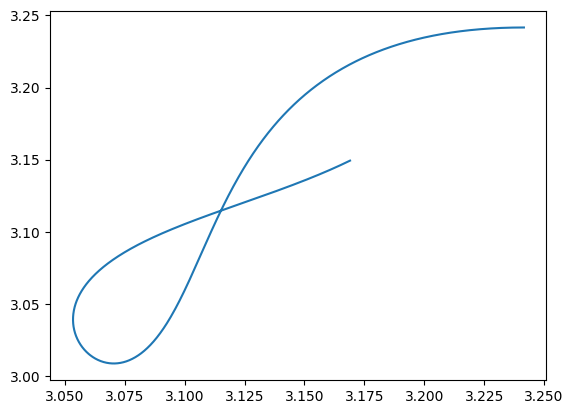

In [166]:
# Generate our data:
generated_data = odeint(dy_dt, init, tsteps, g)

plt.plot(generated_data[:, 0], generated_data[:, 1])

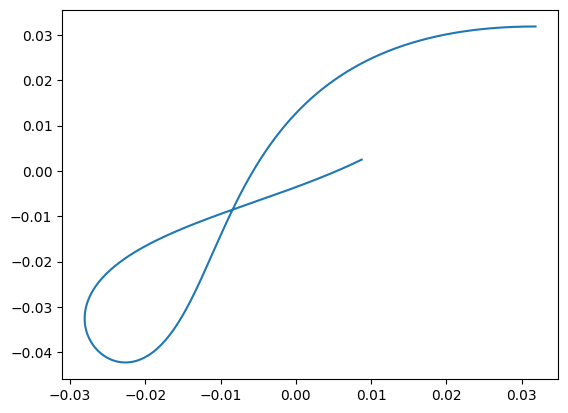

In [167]:
def modulo_two_pi(x):
  return x % (2 * pi)

# Normalise our generated data. We normalise the angles by modulo-ing the angles by 2 pi, dividing by pi (so that values are between 0 and 2), and then subtracting 1,
# so that the valeus are between -1 and 1.
normalised_data = generated_data
normalised_data = normalised_data.at[:,:2].apply(modulo_two_pi)
normalised_data = normalised_data.at[:,:2].divide(pi)
normalised_data = normalised_data.at[:,:2].add(-1)
# To normalise the angular velocities, divide by 100.
normalised_data = normalised_data.at[:,2:].divide(100)

plt.plot(normalised_data[:, 0], normalised_data[:, 1])

# Before we split the data, we need to actually package it into short ordered batches. The idea is we will have:
# the dataset: [y0, y1, .... , yt], where yi = (theta_1i, theta_2i, omega_1i, omega_2i)
# which will then be packaged into smaller, ordered time series batches like this:
# z0 = [y0, y1, ... , yn], z1 = [y(n+1), y(n+2), ... , y(2n)] etc.
# And these can then be put into training batches as we would expect normally.

ordered_batches = []

for i in range(data_points - prediction_batch_size - 1):
  ordered_batches.append(normalised_data[i:i + prediction_batch_size,:])

ordered_batches = jnp.array(ordered_batches)
# Split the data. We need shuffle to be 0 to preserve the time series.
x_train, x_test = train_test_split(ordered_batches, random_state=42)

# Build The Model

In [168]:
# Define our dataset class. This allows us to batch our data when training.
class Dataset:
  """An iterator over a numpy array, revealing batch_size elements at a time."""
  # Initialise our dataset class. It needs the full x and y values and a batch size to be initialised.
  def __init__(self, x: jnp.array, batch_size: int):
    self._x = x
    self._batch_size = batch_size
    self._length = self._x.shape[0]
    # The id stores where the next datapoint should be taken from, so when initialised it should be 0.
    self._idx = 0

  # This is the function that gives us our next batch of data.
  def __next__(self):
    # Start again from beginning of dataset if there are not enough datapoints in front.
    if self._idx + self._batch_size >= self._length:
      self._idx = 0

    # Select the first and last datapoints in the batch. First will be the current value of the ID
    start = self._idx
    end = start + self._batch_size
    # Select our data.
    x= self._x[start:end]
    # This resets us back to 0 once we reach the end of our data.
    if end >= self._length:
      end = end % self._length
      # assert end == 0  # Guaranteed by ctor assertion.
    self._idx = end
    return x

In [169]:
# Now that we have defined our dataset class, we can make our datasets:
train_dataset = Dataset(x_train, training_batch_size)
eval_dataset = Dataset(x_test, training_batch_size)

In [170]:
# Define a batch of data.
class Batch(NamedTuple):
  input: np.ndarray
  output: np.ndarray

# Define a training state, telling us what parameters we have and the state of the optimizer.
class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

In [171]:
# Define the neural network.
def FeedForward(x):
  mlp = hk.Sequential([
      hk.Linear(16), jax.nn.relu,
      hk.Linear(16), jnp.tanh,
      hk.Linear(16), jax.nn.relu,
      hk.Linear(16), jnp.tanh,
      hk.Linear(2),
  ])
  return mlp(x)

# Define our network and optimiser.
network = hk.without_apply_rng(hk.transform(FeedForward))
optimiser = optax.adam(1e-2)

In [172]:
# Define our mean squared error loss.
@jit
def nn_predict(y, t, weights):
  # Our network only predicts the acceleration. Since we are using odeint on it, we need input and output to be the same shape, so we can attach the velocities directly
  # onto it too.
  accel = network.apply(weights, y)
  veloc = y[2:]
  preds = jnp.hstack((veloc, accel))
  return preds

@jit
def modulo_two(x):
  return x % 2

@jit
def normalise_predictions(preds):
  preds = preds.at[:,:2].add(1)
  preds = preds.at[:,:2].apply(modulo_two)
  preds = preds.at[:,:2].add(-1)
  return preds

@jit
def euler_integrator(y, weights, steps):
  prediction = []
  for i in range(prediction_batch_size):
    y = jnp.add(y, dt * nn_predict(y, 0, weights))
    prediction.append(y)
  return jnp.array(prediction)

@jit
def MeanSquaredErrorLoss(weights, batch):
  # WLOG, we can set each time series as starting from 0.
  tsteps = jnp.array([i*dt for i in range(prediction_batch_size)])
  # This array will hold our predictions for each prediction batch.
  preds = []
  # Make our predictions. Our output data is periodic between (-1, 1), but odeint doesn't know that it has to stay within these bounds. Thus,
  # we will have to manually normalise it. To do this, we can add 1 so it is periodic between (0, 2), module by 2, and then subtract 1 again.
  for i in range(training_batch_size):
    prediction = euler_integrator(batch[i, 0], weights, prediction_batch_size)
    #prediction = odeint(nn_predict, batch[i, 0], tsteps, weights)
    prediction = normalise_predictions(prediction)
    # This adds the prediction for batch i to the preds tuple.
    preds.append(prediction)

  preds = jnp.array(preds)
  return jnp.power(batch[1:,:,:2] - preds[1:,:,:2], 2).mean()

In [173]:
@jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
  # This is how we define our stochastic gradient descent.

  # Find grads of loss w.r.t parameters, on this batch of the data
  grads = jax.grad(MeanSquaredErrorLoss)(state.params, batch)
  # Get the updates and the new optimser state from this.
  updates, opt_state = optimiser.update(grads, state.opt_state)
  # Apply the updates to the parameters.
  params = optax.apply_updates(state.params, updates)

  #return the training state with the new parameters and the optimiser.
  return TrainingState(params, opt_state)

In [174]:
#Initialising the parameters randomly.
rng = jax.random.PRNGKey(41)
initial_params = network.init(rng, x_train[1])

# Initialise the optimiser and the define the state.
initial_opt_state = optimiser.init(initial_params)
state = TrainingState(initial_params, initial_opt_state)

# Print the structure of the network.
print("Weights Type : {}\n".format(type(initial_params)))

for layer_name, weights in initial_params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(initial_params[layer_name]["w"].shape,initial_params[layer_name]["b"].shape))

Weights Type : <class 'dict'>

linear
Weights : (4, 16), Biases : (16,)

linear_1
Weights : (16, 16), Biases : (16,)

linear_2
Weights : (16, 16), Biases : (16,)

linear_3
Weights : (16, 16), Biases : (16,)

linear_4
Weights : (16, 2), Biases : (2,)



In [175]:
# Training & evaluation loop.

train_loss_list = []
val_loss_list = []
for step in range(gradient_updates):
  # Do stochastic gradient descent on a batch of training examples.
  state = update(state, next(train_dataset))

  # Print the training and evaluation loss every 1000 time steps. We normalise the loss so that if we change batch size, the loss stays at the same scale.

  if step % 1000 == 0:
    train_loss_list.append(MeanSquaredErrorLoss(state.params, next(train_dataset)) / (training_batch_size * prediction_batch_size))
    val_loss_list.append(MeanSquaredErrorLoss(state.params, next(eval_dataset)) / (training_batch_size * prediction_batch_size))
    print("Step {}: train loss {}, eval loss {}".format(step, train_loss_list[-1], val_loss_list[-1]))

Step 0: train loss 4.704047151804502e-10, eval loss 4.4467246551604944e-10
Step 1000: train loss 4.99744523541068e-10, eval loss 5.012113502012028e-10
Step 2000: train loss 4.3329526078217384e-10, eval loss 3.3134300858606025e-10
Step 3000: train loss 4.0625594555088185e-10, eval loss 5.587190710087953e-10
Step 4000: train loss 4.793120345070179e-10, eval loss 5.250353485308779e-10
Step 5000: train loss 5.184099260979735e-10, eval loss 4.292594613097833e-10
Step 6000: train loss 4.78671158266053e-10, eval loss 5.091096988429911e-10
Step 7000: train loss 3.676246529416005e-10, eval loss 5.809969727543773e-10
Step 8000: train loss 4.408085285678709e-10, eval loss 5.303387173860585e-10


KeyboardInterrupt: ignored

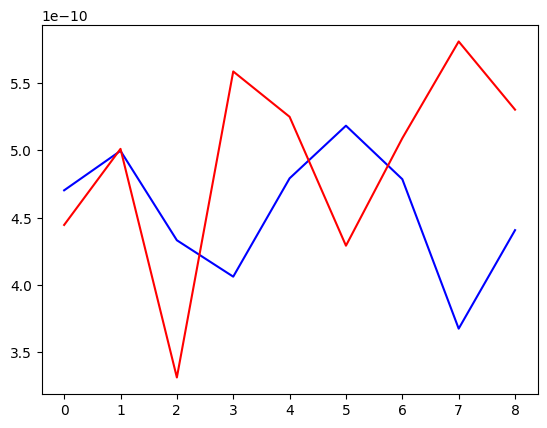

In [176]:
plt.plot(train_loss_list, color="b")
plt.plot(val_loss_list, color="red")

[[3.1830907e-02 3.1830907e-02 0.0000000e+00 0.0000000e+00]
 [3.1830907e-02 3.1830907e-02 4.7107351e-06 1.1669062e-05]
 [3.1830907e-02 3.1830907e-02 9.4200323e-06 2.3339115e-05]
 ...
 [4.1688204e-02 5.9729218e-02 1.0779193e-02 3.0507619e-02]
 [4.1698933e-02 5.9759736e-02 1.0786986e-02 3.0529134e-02]
 [4.1709781e-02 5.9790254e-02 1.0794784e-02 3.0550662e-02]]
[[ 3.1830907e-02  3.1830907e-02  0.0000000e+00  0.0000000e+00]
 [ 3.1830788e-02  3.1830907e-02 -9.7984212e-06 -2.0588985e-11]
 [ 3.1830311e-02  3.1830907e-02 -1.9596664e-05 -2.1964816e-10]
 ...
 [ 8.5700750e-03  2.3555756e-03  2.5624812e-03  2.0597931e-03]
 [ 8.6516142e-03  2.4212599e-03  2.5578889e-03  2.0636609e-03]
 [ 8.7330341e-03  2.4870634e-03  2.5532653e-03  2.0675394e-03]]


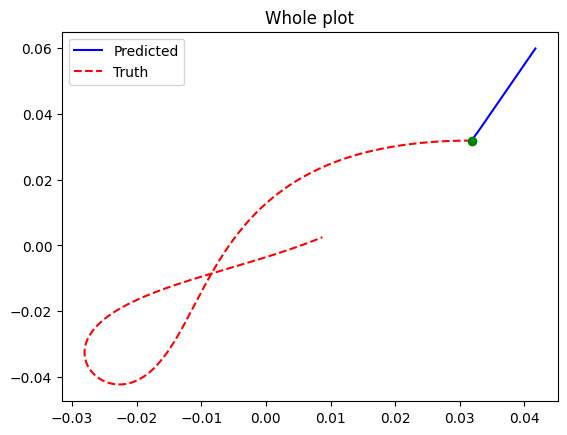

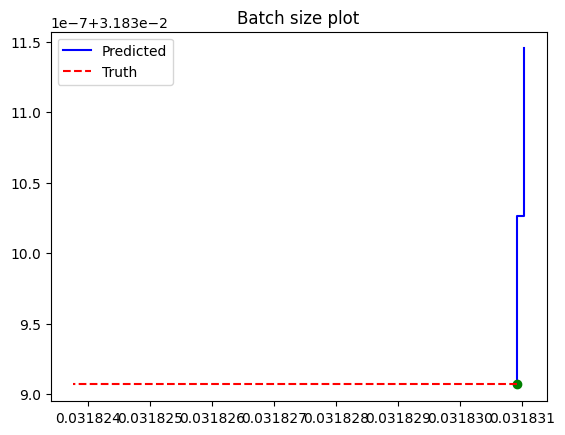

In [177]:
# Generate data from our neural network. odeint doesn't know to normalise it, so we will normalise it in the same way as before.
# Our initial value will be the first point in our normalised data array.
full_steps = jnp.array([dt*i for i in range(data_points)])

#predicted_data = jnp.array(euler_integrator(normalised_data[0], state.params, data_points))
predicted_data = odeint(nn_predict, normalised_data[0], full_steps, state.params)
predicted_data = normalise_predictions(predicted_data)

print(predicted_data)
print(normalised_data)

plt.plot(predicted_data[:, 0], predicted_data[:, 1], color="blue", label="Predicted")
plt.plot(normalised_data[:, 0], normalised_data[:, 1], color="red", label="Truth", linestyle="dashed")
plt.plot(normalised_data[0,0], normalised_data[0,1], "o", color="green")
plt.legend()
plt.title("Whole plot")
plt.show()
plt.close()

plt.plot(predicted_data[:prediction_batch_size, 0], predicted_data[:prediction_batch_size, 1], color="blue", label="Predicted")
plt.plot(normalised_data[0,0], normalised_data[0,1], "o", color="green")
plt.plot(normalised_data[:prediction_batch_size, 0], normalised_data[:prediction_batch_size, 1], color="red", label="Truth", linestyle="dashed")
plt.legend()
plt.title("Batch size plot")
plt.show()
plt.close()

# Create animation of the pendulums

In [ ]:
 # Computes a plot of the angles.
theta_1 = generated_data[:, 0]
theta_2 = generated_data[:, 1]


plt.plot(theta_1, c='b')
plt.plot(theta_2, c='r')

plt.plot(theta_1, theta_2)

Code below will convert the data into a gif.

In [ ]:
# Convert to Cartesian coordinates of the two bob positions.

theta_1 = (1 + predicted_data[:,0]) * pi
theta_2 = (1 + predicted_data[:,1]) * pi

Theta_1 = generated_data[:,0]
Theta_2 = generated_data[:,1]

x1 = sin(theta_1)
y1 = cos(theta_1)
x2 = x1 + sin(theta_2)
y2 = y1 + cos(theta_2)

X1 = sin(Theta_1)
Y1 = cos(Theta_1)
X2 = X1 + sin(Theta_2)
Y2 = Y1 + cos(Theta_2)

# Plotted bob circle radius
r = 0.05
# Plot a trail of the m2 bob's position for the last trail_secs seconds.
trail_secs = 1
# This corresponds to max_trail time points.
max_trail = int(trail_secs / dt)

def make_plot(i):
    # Plot and save an image of the double pendulum configuration for time
    # point i.
    # The pendulum rods.
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')
    # Circles representing the anchor point of rod 1, and bobs 1 and 2.
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    ax.plot([0, X1[i], X2[i]], [0, Y1[i], Y2[i]], lw=2, c='k')
    c3 = Circle((X1[i], Y1[i]), r, fc='g', ec='g', zorder=10)
    c4 = Circle((X2[i], Y2[i]), r, fc='y', ec='y', zorder=10)
    ax.add_patch(c3)
    ax.add_patch(c4)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the
        # trail.
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

        ax.plot(X2[imin:imax], Y2[imin:imax], c='y', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-2-r, 2+r)
    ax.set_ylim(-2-r, 2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig('img{:04d}.png'.format(i//di), dpi=72)
    plt.plot()
    plt.cla()


# Make an image every di time points, corresponding to a frame rate of fps
# frames per second.
# Frame rate, s-1
fps = 10
di = int(1/fps/dt)
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

for i in range(0, tsteps.size, di):
    print(i // di, '/', tsteps.size // di)
    make_plot(i)

In [ ]:
frames = []
for i in range(int(tsteps.size) // di):
  image = imageio.v2.imread(f'img{i:04}.png')
  frames.append(image)

imageio
imageio.mimsave('./example.gif', # output gif
                frames,          # array of input frames
                fps = 10)         # optional: frames per second """

